In this assignment you'll have to explore and classify time series. The dataset is [FordA](http://www.timeseriesclassification.com/description.php?Dataset=FordA), which is a set of recordings of engine noise under typical conditions and you need to classify if certain condition exists.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.style.use("bmh")
plt.rcParams["figure.figsize"] = (6,6)

In [2]:
# Plotting imports
import seaborn as sns

In [3]:
# Generic imports
import pathlib

# DS imports
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, roc_auc_score, roc_curve, classification_report

## Constants

In [4]:
DATA_DIR = pathlib.Path(".")
DATASET = "FordA"

# Loading the data

Data files are stored in tabular format:

In [5]:
train = pd.read_csv(DATA_DIR.joinpath(DATASET, f"{DATASET}_TRAIN.txt"),
                    header=None,
                    sep=r"\s+",
                    skipinitialspace=True)
test = pd.read_csv(DATA_DIR.joinpath(DATASET, f"{DATASET}_TEST.txt"),
                   header=None,
                   sep=r"\s+",
                   skipinitialspace=True)

In [6]:
train.head()

0         1         2         3         4         5         6         7    \
0 -1.0 -0.797172 -0.664392 -0.373015  0.040815  0.526936  0.984288  1.353120   
1  1.0  0.804855  0.634629  0.373474  0.038343 -0.340988 -0.740860 -1.109667   
2 -1.0  0.727985  0.111284 -0.499124 -1.068629 -1.578351 -1.990534 -2.302031   
3 -1.0 -0.234439 -0.502157 -0.732488 -0.946128 -1.139739 -1.323336 -1.490243   
4 -1.0 -0.171328 -0.062285  0.235829  0.710396  1.239969  1.649823  1.876321   

        8         9    ...       491       492       493       494       495  \
0  1.578108  1.659251  ...  1.120756  0.722417  0.362068  0.092083 -0.081268   
1 -1.395357 -1.570192  ...  0.386403  0.049213 -0.258138 -0.510583 -0.683647   
2 -2.503403 -2.585211  ...  0.394463  0.463685  0.507735  0.517174  0.504588   
3 -1.607077 -1.620430  ... -0.952804 -0.929437 -0.922761 -0.929437 -0.909409   
4  1.865535  1.703751  ...  0.776188  0.725496  0.697453  0.731967  0.808545   

        496       497       498       499       500  
0 -0.212573 -0.391456 -0.664392 -1.073796 -1.564343  
1 -0.773817 -0.785255 -0.714885 -0.560443 -0.319086  
2  0.476270  0.438513  0.394463  0.339400  0.255391  
3 -0.835970 -0.695768 -0.478790 -0.188707  0.119736  
4  0.839823  0.733046  0.437520 -0.026585 -0.602213  

[5 rows x 501 columns]

So, each row represents a single measurement, with column `0` being class label, and columns `1-501` being measured values. Let's check missing values:

In [7]:
train.notnull().sum(axis=1).unique()

array([501], dtype=int64)

In [8]:
test.notnull().sum(axis=1).unique()

array([501], dtype=int64)

Let's change column names to something meaningful:

In [9]:
train.rename({0: "label"}, axis=1, inplace=True)
test.rename({0: "label"}, axis=1, inplace=True)

In [10]:
train.rename({cl: f"val_{cl}" for cl in range(1, 501)}, axis=1, inplace=True)
test.rename({cl: f"val_{cl}" for cl in range(1, 501)}, axis=1, inplace=True)

We can now select data values by filtering:

In [11]:
train.filter(like="val_")

val_1     val_2     val_3     val_4     val_5     val_6     val_7  \
0    -0.797172 -0.664392 -0.373015  0.040815  0.526936  0.984288  1.353120   
1     0.804855  0.634629  0.373474  0.038343 -0.340988 -0.740860 -1.109667   
2     0.727985  0.111284 -0.499124 -1.068629 -1.578351 -1.990534 -2.302031   
3    -0.234439 -0.502157 -0.732488 -0.946128 -1.139739 -1.323336 -1.490243   
4    -0.171328 -0.062285  0.235829  0.710396  1.239969  1.649823  1.876321   
...        ...       ...       ...       ...       ...       ...       ...   
3596  0.196022 -0.070102 -0.336226 -0.516799 -0.555282 -0.442793 -0.221369   
3597  0.041994  0.422255  0.740529  0.975426  1.109891  1.137270  1.058349   
3598 -0.570054 -0.333165 -0.293519 -0.425344 -0.590869 -0.615648 -0.348033   
3599  2.006732  2.079150  2.022036  1.867560  1.648112  1.379446  1.093717   
3600 -0.125241 -0.325363 -0.488237 -0.599045 -0.651111 -0.647106 -0.595040   

         val_8     val_9    val_10  ...   val_491   val_492   val_493  \
0     1.578108  1.659251  1.640809  ...  1.120756  0.722417  0.362068   
1    -1.395357 -1.570192 -1.619951  ...  0.386403  0.049213 -0.258138   
2    -2.503403 -2.585211 -2.550600  ...  0.394463  0.463685  0.507735   
3    -1.607077 -1.620430 -1.506933  ... -0.952804 -0.929437 -0.922761   
4     1.865535  1.703751  1.466467  ...  0.776188  0.725496  0.697453   
...        ...       ...       ...  ...       ...       ...       ...   
3596  0.025217  0.233320  0.350545  ...  1.715205  1.129082  0.528158   
3597  0.894955  0.671224  0.421544  ... -0.463329 -0.392667 -0.333749   
3598  0.275412  1.153586  2.035725  ...  0.902821  0.579700  0.157463   
3599  0.784057  0.434150  0.029284  ...  1.268671  1.148971  0.928088   
3600 -0.502922 -0.388109 -0.259946  ...  0.005352  0.157920  0.288753   

       val_494   val_495   val_496   val_497   val_498   val_499   val_500  
0     0.092083 -0.081268 -0.212573 -0.391456 -0.664392 -1.073796 -1.564343  
1    -0.510583 -0.683647 -0.773817 -0.785255 -0.714885 -0.560443 -0.319086  
2     0.517174  0.504588  0.476270  0.438513  0.394463  0.339400  0.255391  
3    -0.929437 -0.909409 -0.835970 -0.695768 -0.478790 -0.188707  0.119736  
4     0.731967  0.808545  0.839823  0.733046  0.437520 -0.026585 -0.602213  
...        ...       ...       ...       ...       ...       ...       ...  
3596 -0.039020 -0.573043 -1.061479 -1.514392 -1.934743 -2.316612 -2.603753  
3597 -0.316543 -0.340299 -0.392876 -0.450805 -0.482609 -0.467769 -0.393755  
3598 -0.353980 -0.885246 -1.314421 -1.512655 -1.393714 -0.942733 -0.270722  
3599  0.634953  0.311682 -0.007376 -0.270543 -0.432145 -0.441231 -0.280709  
3600  0.384876  0.451628  0.497019  0.527725  0.555761  0.574451  0.573116  

[3601 rows x 500 columns]

The dataset is almost balanced:

In [12]:
train.iloc[:, 0].value_counts()

-1.0    1846
 1.0    1755
Name: label, dtype: int64

In [13]:
test.iloc[:, 0].value_counts()

-1.0    681
 1.0    639
Name: label, dtype: int64

# Task 1: explore time series

In this task you need to plot data samples with class label designation. Consider 10 or 20 random samples, and create a `2 x 5` or `4 x 5` plot, with eash subplot being the data records (i. e. `train.filter(like="val_").iloc[<sample_idx>]`), subtitles displaying sample index and class label. You can use color as well.

In [14]:
N_SAMPLES = 20
N_COLS = 5
N_ROWS = 20 // N_COLS

samples = train.sample(N_SAMPLES, replace=False)

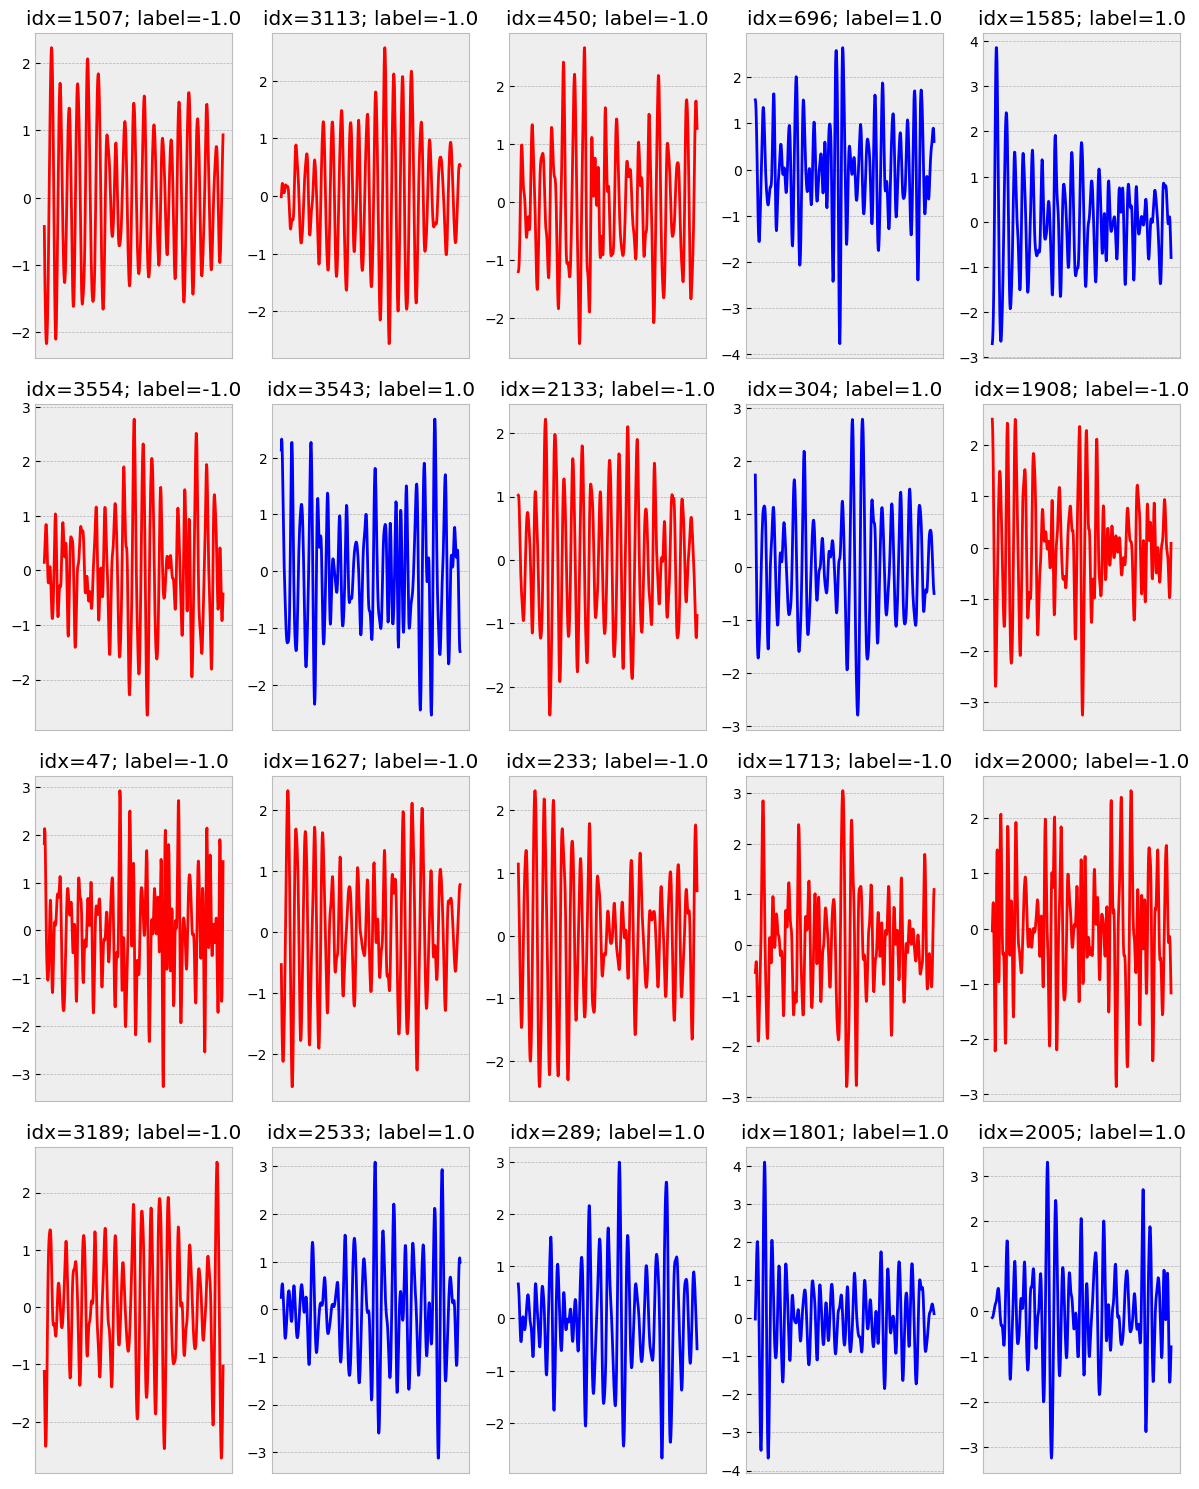

In [15]:
plt.figure(figsize=(3 * N_ROWS, 3 * N_COLS))

for si, (sidx, sample) in enumerate(samples.iterrows()):
    plt.subplot(N_ROWS, N_COLS, si+1)
    color = 'b' if sample.label == 1 else 'r'
    plt.plot(train.filter(like="val_").iloc[sidx], color=color)
    plt.title(f"idx={sidx}; label={sample.label}")
    # Don't show axis ticks or tick labels.
    plt.gca().axes.get_xaxis().set_visible(False)

plt.tight_layout();

# Task 2: explore statistics

In this task you need to plot simple statistics for each class, i. e. calculate `mean`, `median`, `std` and other statistics (of your choice) for each row and then visualize them in such a way, that one can figure out if a distribution of a given statistics differs between class `1` and `-1`.

**Hint:** you can consider [violin plots](https://seaborn.pydata.org/examples/grouped_violinplots.html) or [scatter plot matrix](https://seaborn.pydata.org/examples/scatterplot_matrix.html) helpful.

## Example: median

In [16]:
train["data_median"] = train.filter(like="val_").median(axis=1)
test["data_median"] = test.filter(like="val_").median(axis=1)

The simplest visualization possible (you need to create smth more elaborated for other features altogether):

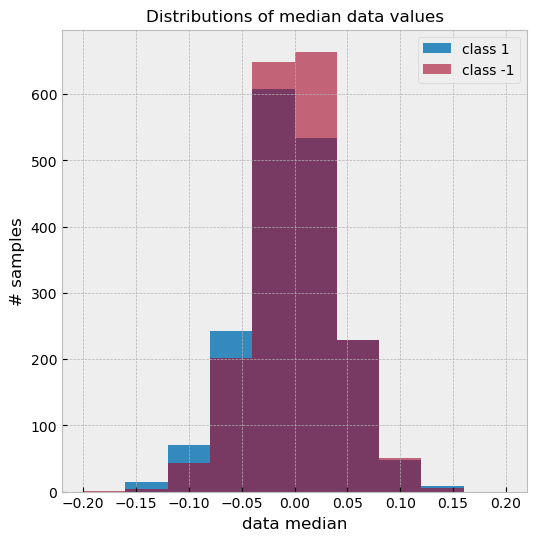

In [17]:
train.loc[train["label"]==1, "data_median"].plot(kind="hist", range=(-0.2, 0.2), label="class 1")
train.loc[train["label"]==-1, "data_median"].plot(kind="hist", range=(-0.2, 0.2), alpha=0.6, label="class -1")

plt.legend(loc=0)
plt.xlabel("data median")
plt.ylabel("# samples")
plt.title("Distributions of median data values", fontsize=12);

**Note:** we can easily check if median is a good feature with ROC curve and score (as they do not rely on any specific normalization of the "predicted" probabilities). Think on why we're using `-data_median`.

In [18]:
fpr, tpr, thr = roc_curve(train["label"], -train["data_median"])

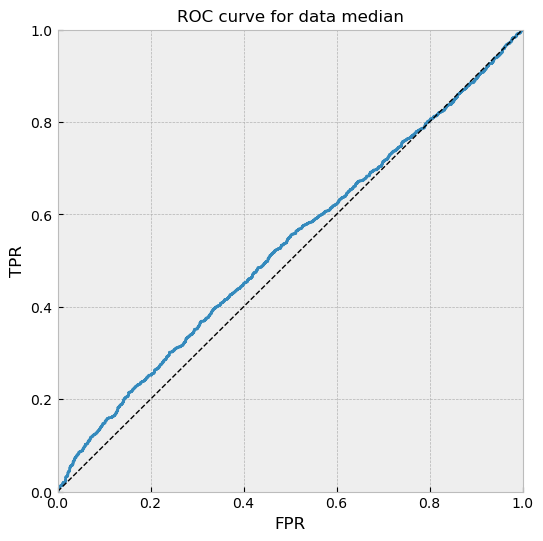

In [19]:
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], "--", c="k", linewidth=1)
plt.xlim(0, 1)
plt.ylim(0, 1)

plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("ROC curve for data median", fontsize=12);

Ok, median contains *some* information (i. e. looking at median values is better than random classifier), but cannot serve as a *single* feature.

## Exploration

In [20]:
# plot other statistics here - mean, std, skew, max, min, some quantiles
# consider calculating ROC AUC for each feature to perform a preliminary filtering of irrelevant features
# beware of NaNs - some statistics may be broken for some rows

In [21]:
def plot_class_distributions(data, feature):
    data.loc[data["label"]==1, feature].plot(kind="hist", label="class 1")
    data.loc[data["label"]==-1, feature].plot(kind="hist", alpha=0.6, label="class -1")

    plt.legend(loc=0)
    plt.xlabel(feature)
    plt.ylabel("# samples")
    plt.title(f"Distributions of {feature}", fontsize=12)
    plt.show()

def plot_violin(data, col_name):
    sns.violinplot(data=data, y=data[col_name], x='label', split=True, linewidth=1)
    plt.show()

def plot_roc(data, feature):
    feature_data = data[feature]
    auc = roc_auc_score(data["label"], feature_data)

    # If AUC is less than 0.5, invert the feature.
    if auc < 0.5:
        feature_data = -feature_data
        feature = "-" + feature

    fpr, tpr, thr = roc_curve(data["label"], feature_data)
    auc = roc_auc_score(data["label"], feature_data)

    plt.plot(fpr, tpr)
    plt.plot([0, 1], [0, 1], "--", c="k", linewidth=1)
    plt.xlim(0, 1)
    plt.ylim(0, 1)

    plt.xlabel("FPR")
    plt.ylabel("TPR")
    plt.title(f"ROC for {feature}; AUC = {auc:.4f}", fontsize=12)
    plt.show()

In [22]:
# Calculate statistics and add to DataFrame.
stats = ["median", "mean", "std", "skew", "min", "max", "kurtosis"]
for stat in stats:
    stats_col_name = f"data_{stat}"
    train[stats_col_name] = train.filter(like="val_").agg(stat, axis=1)
    test[stats_col_name] = test.filter(like="val_").agg(stat, axis=1)

# Add quartiles.
stat = "upper_quartile"
stats.append(stat)
col = f"data_{stat}"
train[col] = train.filter(like="val_").quantile(0.75, axis=1)
test[col] = test.filter(like="val_").quantile(0.75, axis=1)

stat = "lower_quartile"
stats.append(stat)
col = f"data_{stat}"
train[col] = train.filter(like="val_").quantile(0.25, axis=1)
test[col] = test.filter(like="val_").quantile(0.25, axis=1)

stat = "iqr"
stats.append(stat)
col = f"data_{stat}"
train[col] = train["data_upper_quartile"] - train["data_lower_quartile"]
test[col] = test["data_upper_quartile"] - test["data_lower_quartile"]

In [23]:
print("Number of Missing Values:")
for stat in stats:
    col = f"data_{stat}"
    print(f"    {stat}: {train[col].isna().sum()}")

Number of Missing Values:
    median: 0
    mean: 0
    std: 0
    skew: 0
    min: 0
    max: 0
    kurtosis: 0
    upper_quartile: 0
    lower_quartile: 0
    iqr: 0


##### Show Distributions

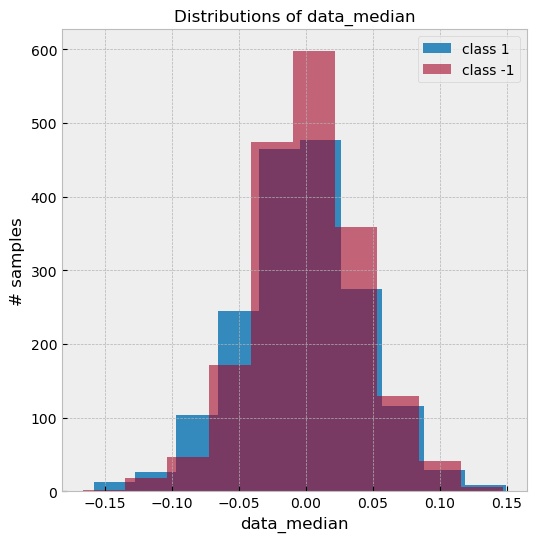

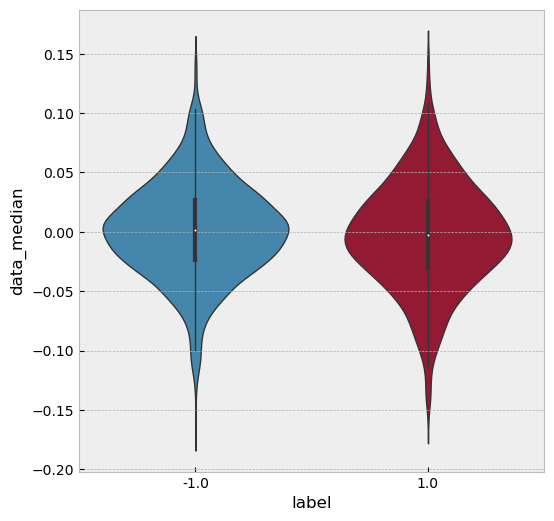

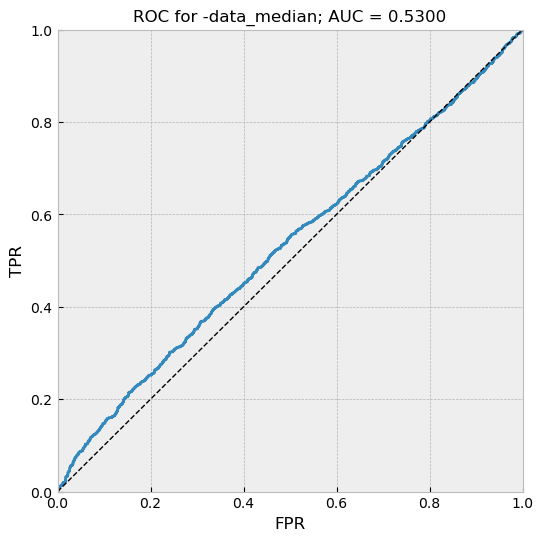

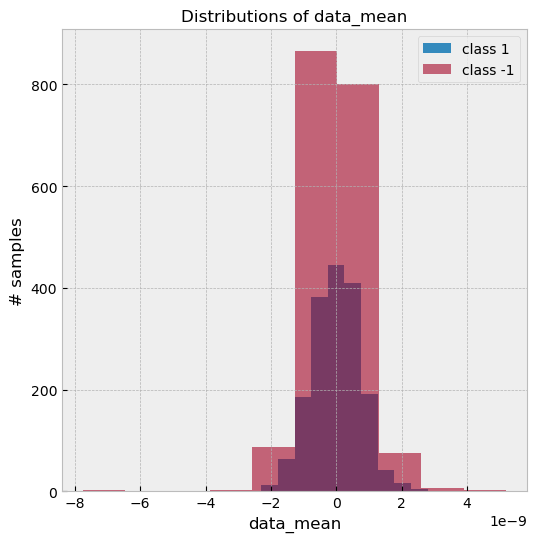

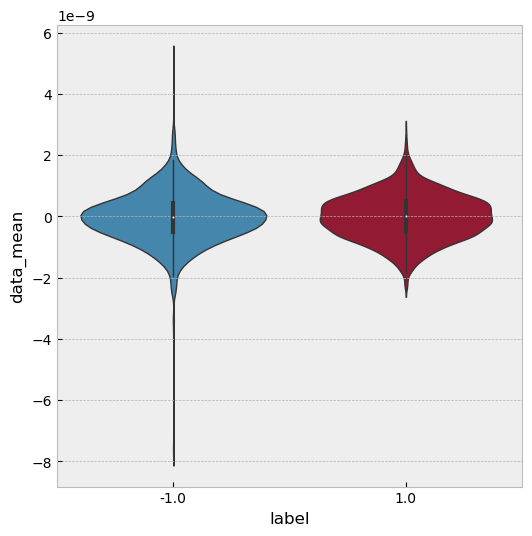

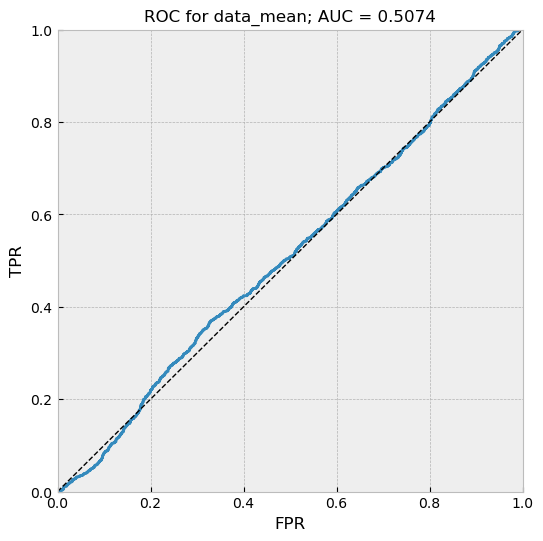

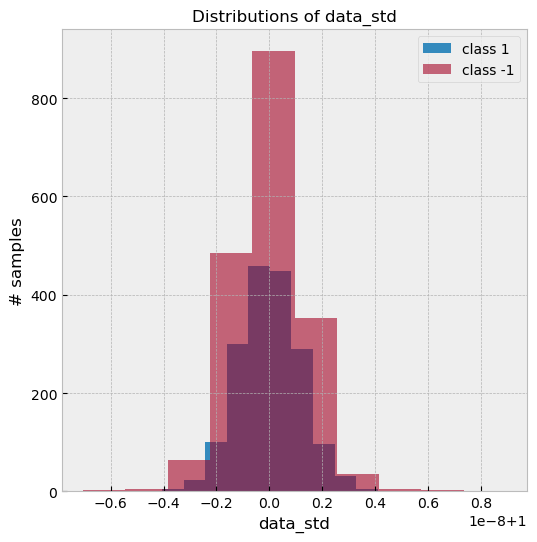

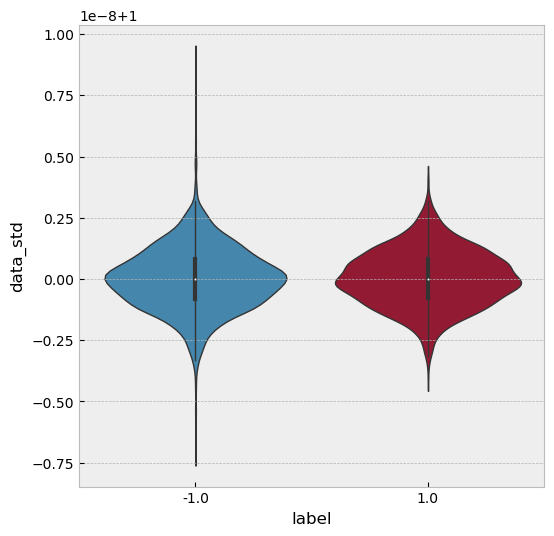

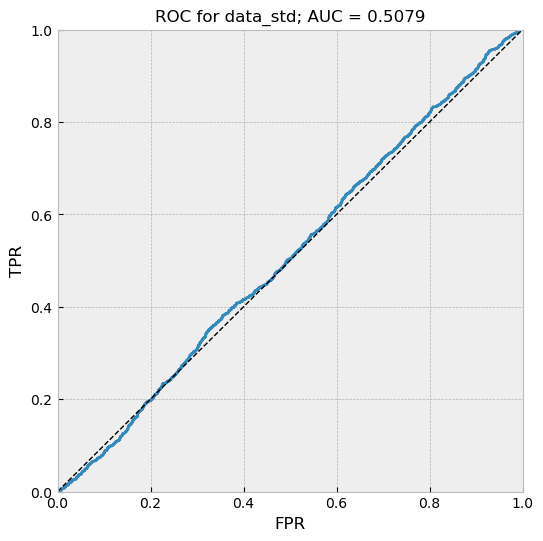

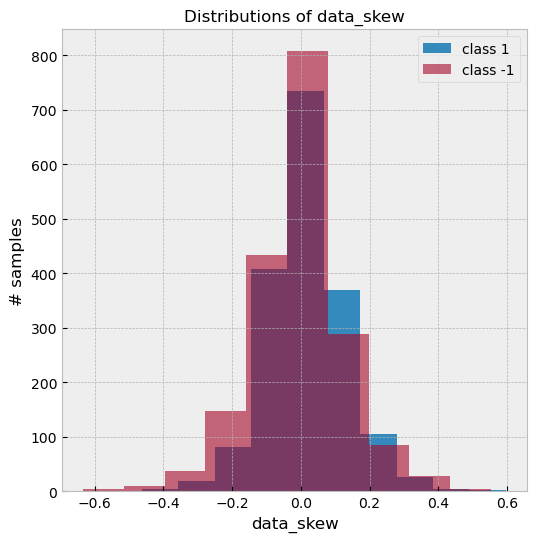

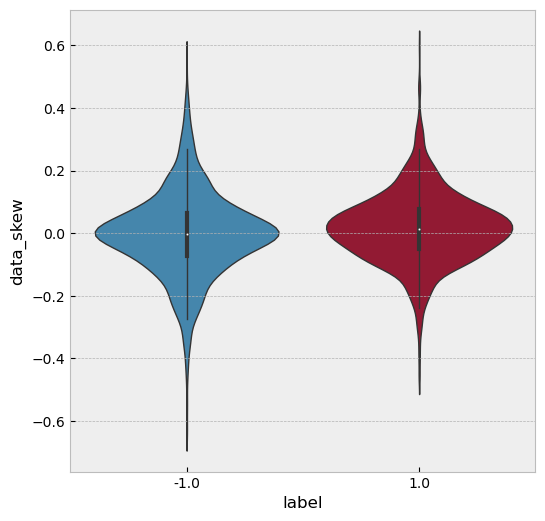

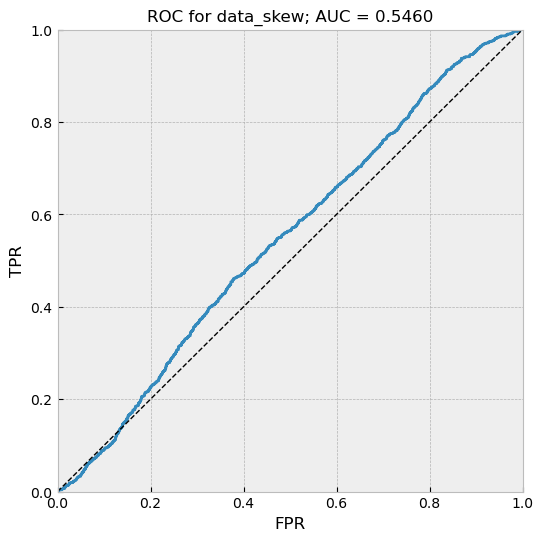

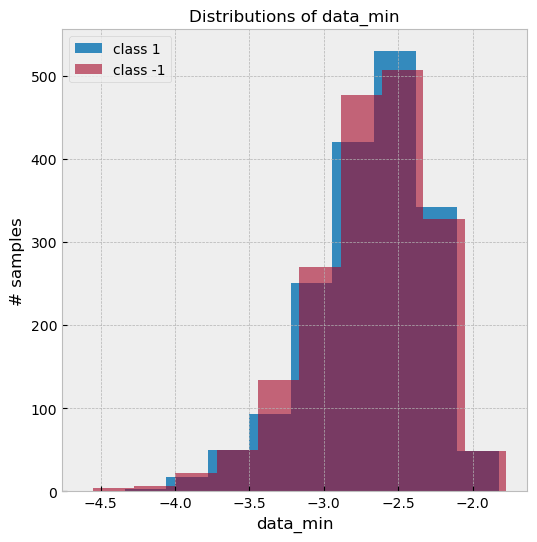

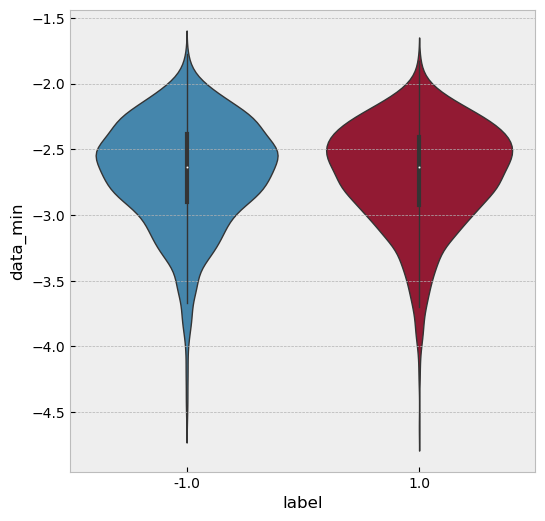

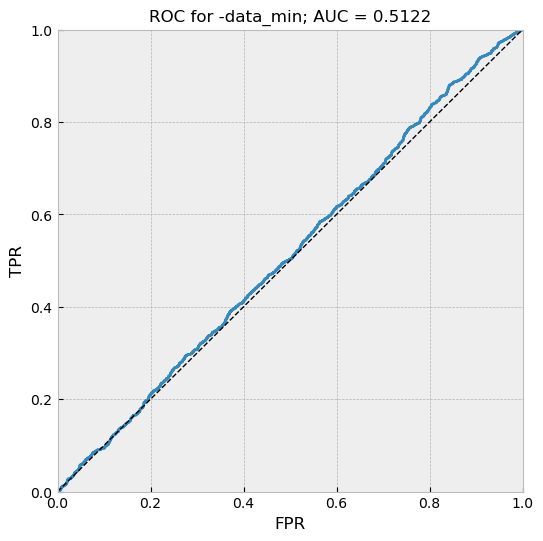

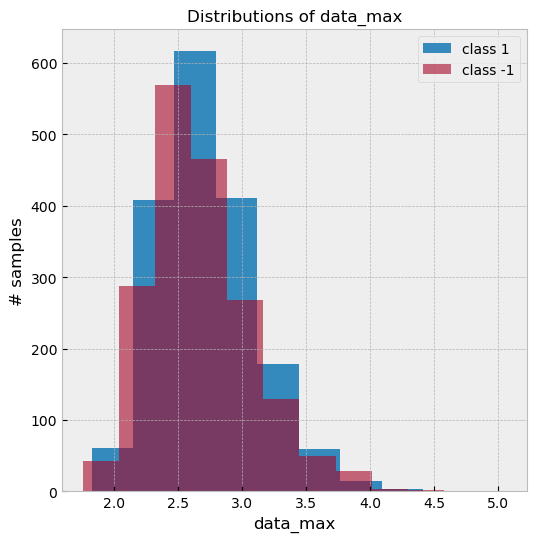

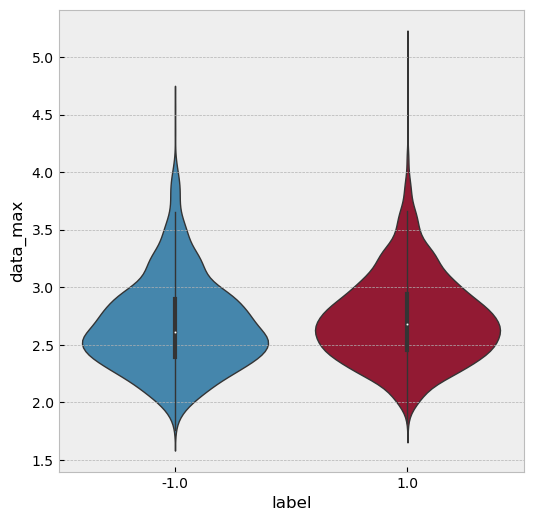

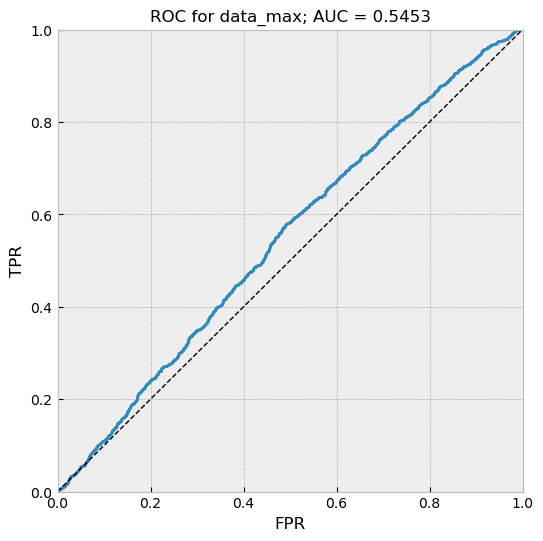

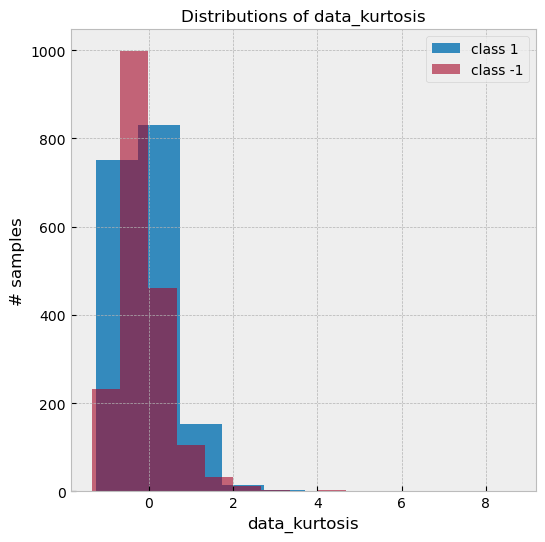

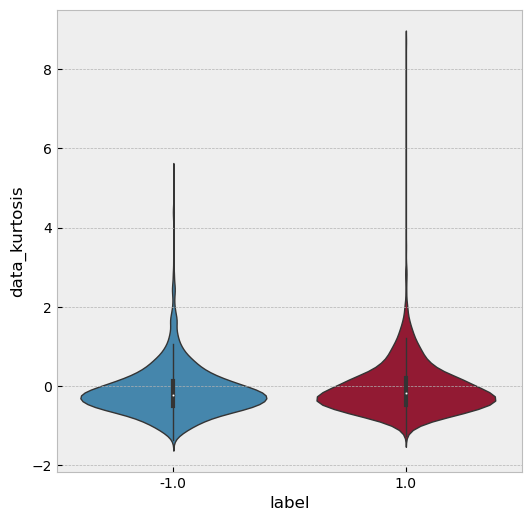

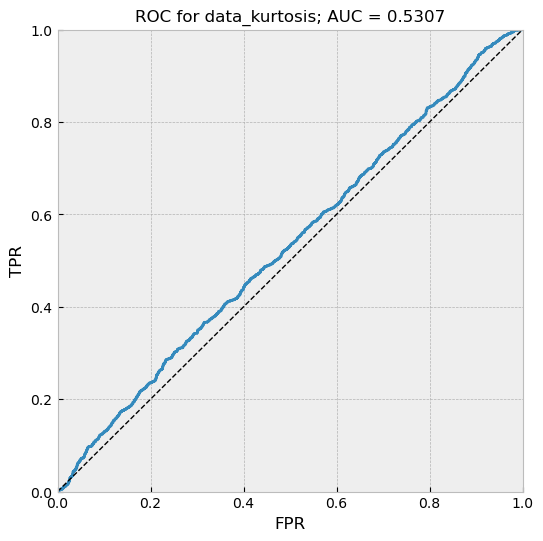

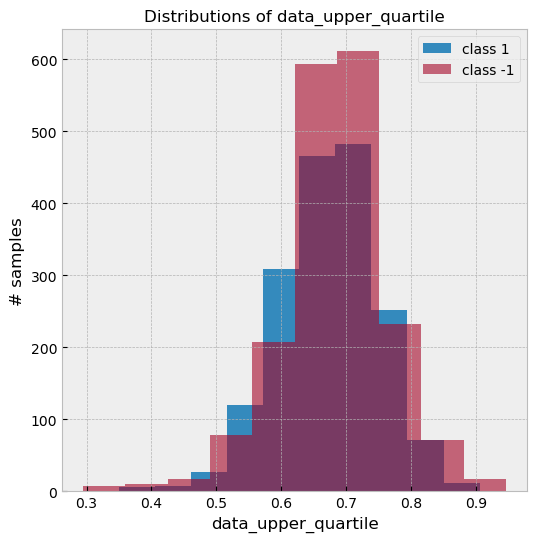

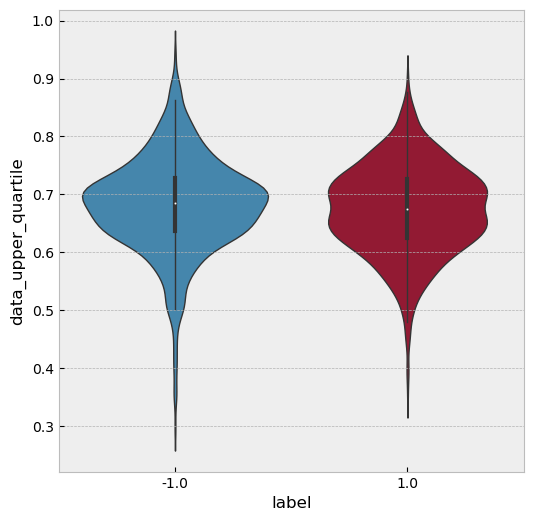

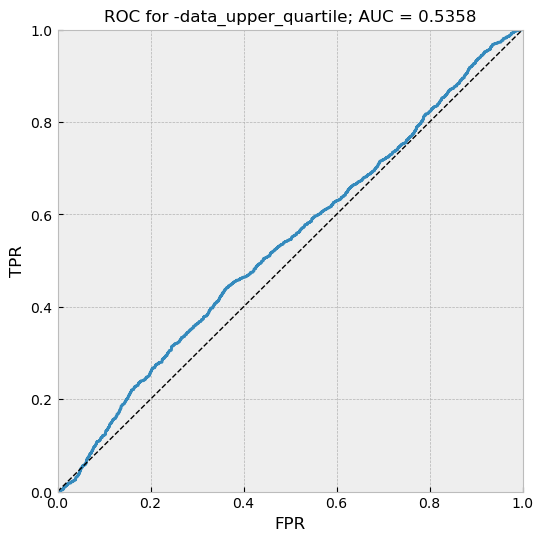

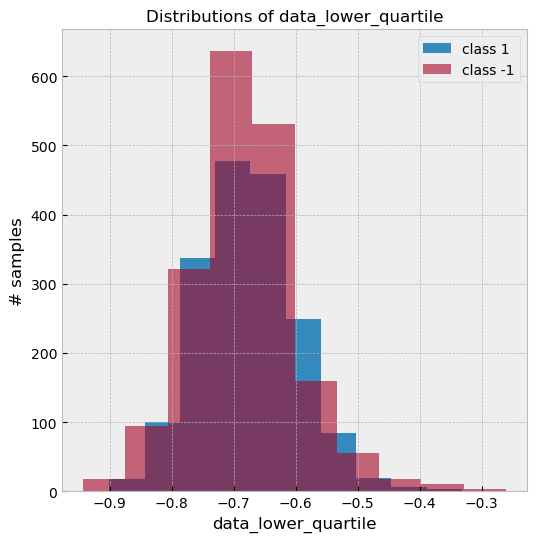

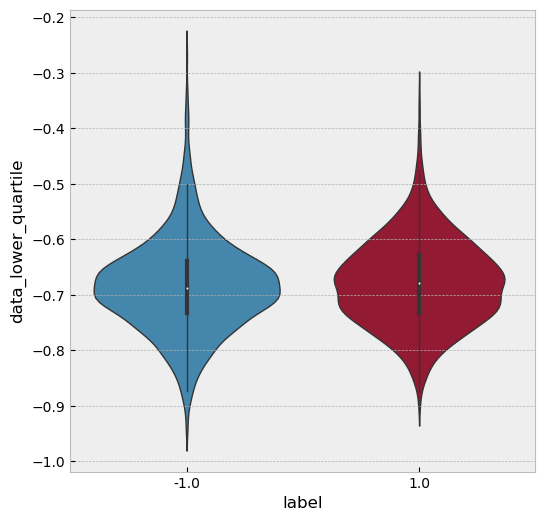

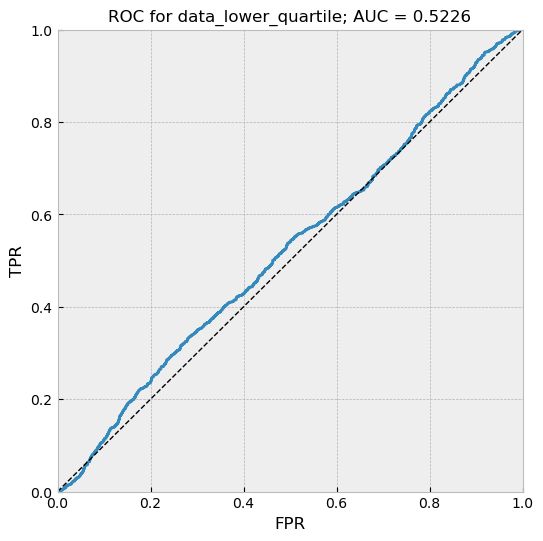

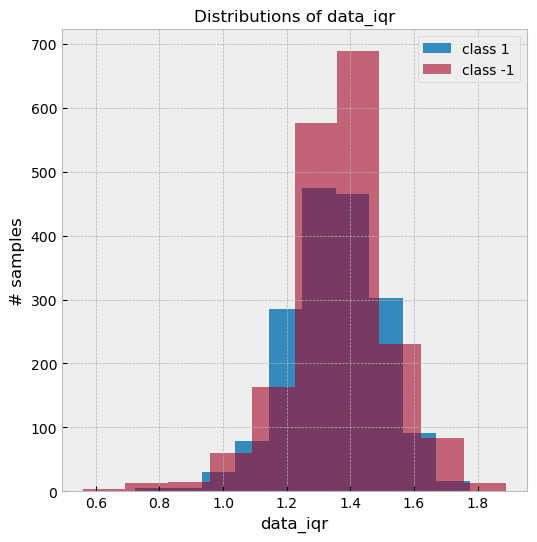

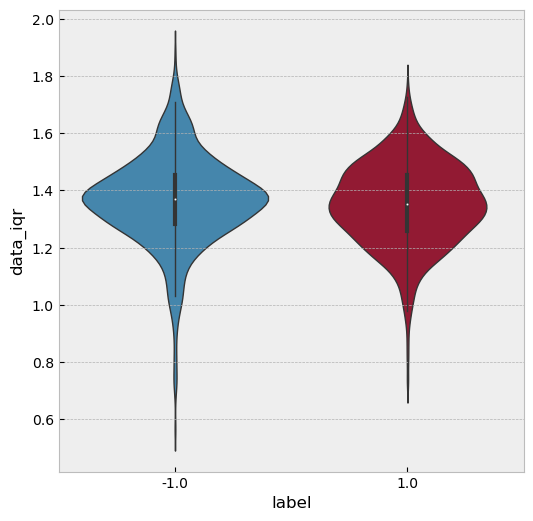

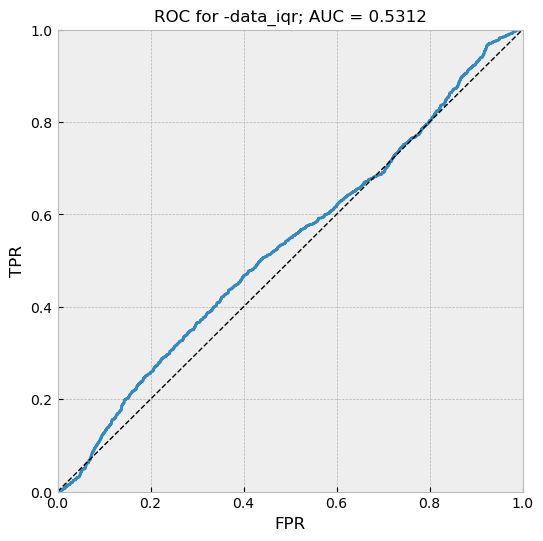

In [24]:
for stat in stats:
    feature = f"data_{stat}"
    plot_class_distributions(train, feature)
    plot_violin(train, feature)
    plot_roc(train, feature)

#### Correlation

In [25]:
train.filter(like="data_").corr()

data_median  data_mean  data_std  data_skew  data_min  \
data_median             1.000000  -0.012120 -0.013912  -0.481903 -0.040728   
data_mean              -0.012120   1.000000  0.029269   0.005143 -0.008866   
data_std               -0.013912   0.029269  1.000000  -0.012670 -0.009050   
data_skew              -0.481903   0.005143 -0.012670   1.000000  0.380041   
data_min               -0.040728  -0.008866 -0.009050   0.380041  1.000000   
data_max               -0.028888   0.005186 -0.009187   0.330362 -0.462441   
data_kurtosis           0.003897   0.005521  0.007925  -0.046703 -0.755782   
data_upper_quartile    -0.067103   0.008013  0.014138  -0.120465  0.472894   
data_lower_quartile    -0.031610   0.001683 -0.000729  -0.172536 -0.565681   
data_iqr               -0.018376   0.003306  0.007800   0.028572  0.548694   

                     data_max  data_kurtosis  data_upper_quartile  \
data_median         -0.028888       0.003897            -0.067103   
data_mean            0.005186       0.005521             0.008013   
data_std            -0.009187       0.007925             0.014138   
data_skew            0.330362      -0.046703            -0.120465   
data_min            -0.462441      -0.755782             0.472894   
data_max             1.000000       0.753853            -0.576915   
data_kurtosis        0.753853       1.000000            -0.766134   
data_upper_quartile -0.576915      -0.766134             1.000000   
data_lower_quartile  0.480775       0.770645            -0.793592   
data_iqr            -0.558091      -0.811414             0.946230   

                     data_lower_quartile  data_iqr  
data_median                    -0.031610 -0.018376  
data_mean                       0.001683  0.003306  
data_std                       -0.000729  0.007800  
data_skew                      -0.172536  0.028572  
data_min                       -0.565681  0.548694  
data_max                        0.480775 -0.558091  
data_kurtosis                   0.770645 -0.811414  
data_upper_quartile            -0.793592  0.946230  
data_lower_quartile             1.000000 -0.947751  
data_iqr                       -0.947751  1.000000

#### Pair Plots
- Unable to visualize clear separation between the labels for each statistic

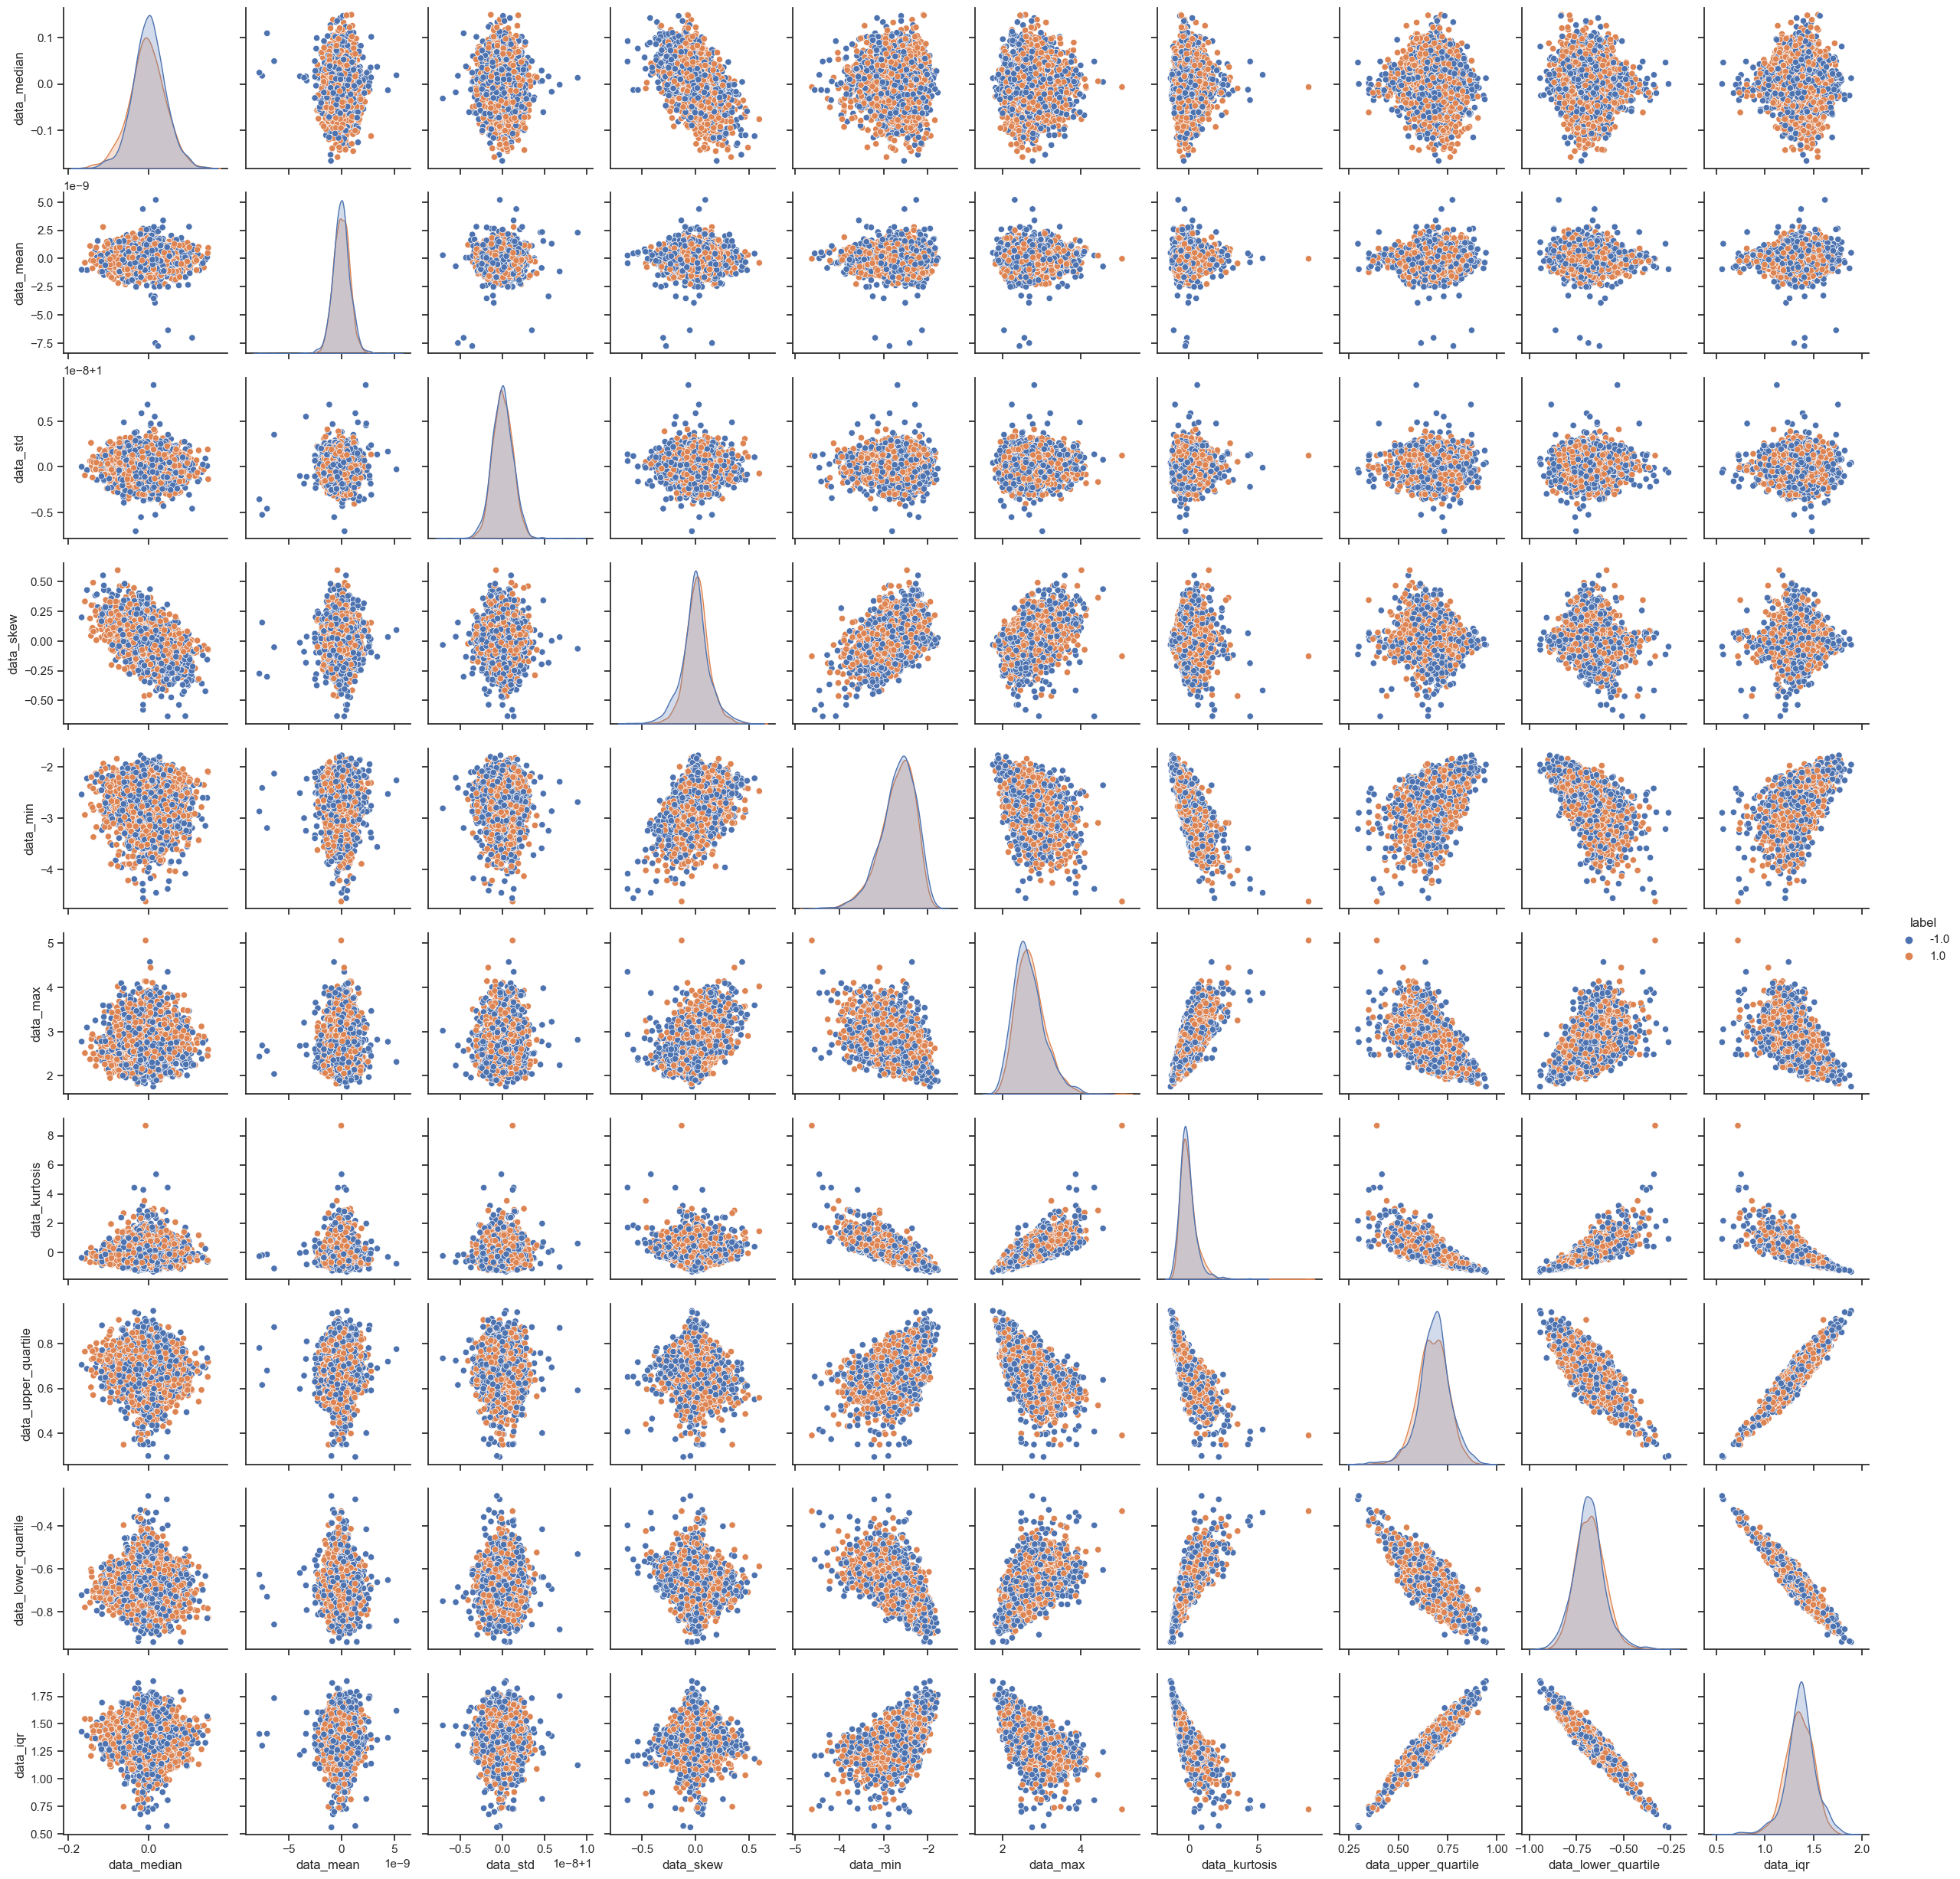

In [26]:
sns.set_theme(style="ticks")
temp_df = pd.concat([train.filter(like="data_"), train.label], axis=1)
sns.pairplot(data=temp_df, hue="label", palette='deep');

# Task 3: explore advanced features

In this task you need to calculate and analyze other time series features. looking on the data sample, think on which features in time/frequency domains may be useful for a classification of the dataset.

**Hint:** try various features from [`tsfresh`](https://tsfresh.readthedocs.io/en/latest/text/list_of_features.html).

## Example: 0-crossings

For this features we'll not use `tsfresh`, and will do some ninja stuff in Pandas itself:

**Step 1:** mask on `> 0`.

In [27]:
mask = (train.filter(like="val_") > 0).astype(int)
mask

val_1  val_2  val_3  val_4  val_5  val_6  val_7  val_8  val_9  val_10  \
0         0      0      0      1      1      1      1      1      1       1   
1         1      1      1      1      0      0      0      0      0       0   
2         1      1      0      0      0      0      0      0      0       0   
3         0      0      0      0      0      0      0      0      0       0   
4         0      0      1      1      1      1      1      1      1       1   
...     ...    ...    ...    ...    ...    ...    ...    ...    ...     ...   
3596      1      0      0      0      0      0      0      1      1       1   
3597      1      1      1      1      1      1      1      1      1       1   
3598      0      0      0      0      0      0      0      1      1       1   
3599      1      1      1      1      1      1      1      1      1       1   
3600      0      0      0      0      0      0      0      0      0       0   

      ...  val_491  val_492  val_493  val_494  val_495  val_496  val_497  \
0     ...        1        1        1        1        0        0        0   
1     ...        1        1        0        0        0        0        0   
2     ...        1        1        1        1        1        1        1   
3     ...        0        0        0        0        0        0        0   
4     ...        1        1        1        1        1        1        1   
...   ...      ...      ...      ...      ...      ...      ...      ...   
3596  ...        1        1        1        0        0        0        0   
3597  ...        0        0        0        0        0        0        0   
3598  ...        1        1        1        0        0        0        0   
3599  ...        1        1        1        1        1        0        0   
3600  ...        1        1        1        1        1        1        1   

      val_498  val_499  val_500  
0           0        0        0  
1           0        0        0  
2           1        1        1  
3           0        0        1  
4           1        0        0  
...       ...      ...      ...  
3596        0        0        0  
3597        0        0        0  
3598        0        0        0  
3599        0        0        0  
3600        1        1        1  

[3601 rows x 500 columns]

**Step 2:** calc `diff` to get crossings (from `< 0` to `> 0`, or other way around).

In [28]:
mask.diff(axis=1) == 1  # crossing from -0 to +0

val_1  val_2  val_3  val_4  val_5  val_6  val_7  val_8  val_9  val_10  \
0     False  False  False   True  False  False  False  False  False   False   
1     False  False  False  False  False  False  False  False  False   False   
2     False  False  False  False  False  False  False  False  False   False   
3     False  False  False  False  False  False  False  False  False   False   
4     False  False   True  False  False  False  False  False  False   False   
...     ...    ...    ...    ...    ...    ...    ...    ...    ...     ...   
3596  False  False  False  False  False  False  False   True  False   False   
3597  False  False  False  False  False  False  False  False  False   False   
3598  False  False  False  False  False  False  False   True  False   False   
3599  False  False  False  False  False  False  False  False  False   False   
3600  False  False  False  False  False  False  False  False  False   False   

      ...  val_491  val_492  val_493  val_494  val_495  val_496  val_497  \
0     ...    False    False    False    False    False    False    False   
1     ...    False    False    False    False    False    False    False   
2     ...    False    False    False    False    False    False    False   
3     ...    False    False    False    False    False    False    False   
4     ...    False    False    False    False    False    False    False   
...   ...      ...      ...      ...      ...      ...      ...      ...   
3596  ...    False    False    False    False    False    False    False   
3597  ...    False    False    False    False    False    False    False   
3598  ...    False    False    False    False    False    False    False   
3599  ...    False    False    False    False    False    False    False   
3600  ...     True    False    False    False    False    False    False   

      val_498  val_499  val_500  
0       False    False    False  
1       False    False    False  
2       False    False    False  
3       False    False     True  
4       False    False    False  
...       ...      ...      ...  
3596    False    False    False  
3597    False    False    False  
3598    False    False    False  
3599    False    False    False  
3600    False    False    False  

[3601 rows x 500 columns]

In [29]:
mask.diff(axis=1) == -1  # crossing from +0 to -0

val_1  val_2  val_3  val_4  val_5  val_6  val_7  val_8  val_9  val_10  \
0     False  False  False  False  False  False  False  False  False   False   
1     False  False  False  False   True  False  False  False  False   False   
2     False  False   True  False  False  False  False  False  False   False   
3     False  False  False  False  False  False  False  False  False   False   
4     False  False  False  False  False  False  False  False  False   False   
...     ...    ...    ...    ...    ...    ...    ...    ...    ...     ...   
3596  False   True  False  False  False  False  False  False  False   False   
3597  False  False  False  False  False  False  False  False  False   False   
3598  False  False  False  False  False  False  False  False  False   False   
3599  False  False  False  False  False  False  False  False  False   False   
3600  False  False  False  False  False  False  False  False  False   False   

      ...  val_491  val_492  val_493  val_494  val_495  val_496  val_497  \
0     ...    False    False    False    False     True    False    False   
1     ...    False    False     True    False    False    False    False   
2     ...    False    False    False    False    False    False    False   
3     ...    False    False    False    False    False    False    False   
4     ...    False    False    False    False    False    False    False   
...   ...      ...      ...      ...      ...      ...      ...      ...   
3596  ...    False    False    False     True    False    False    False   
3597  ...    False    False    False    False    False    False    False   
3598  ...    False    False    False     True    False    False    False   
3599  ...    False    False    False    False    False     True    False   
3600  ...    False    False    False    False    False    False    False   

      val_498  val_499  val_500  
0       False    False    False  
1       False    False    False  
2       False    False    False  
3       False    False    False  
4       False     True    False  
...       ...      ...      ...  
3596    False    False    False  
3597    False    False    False  
3598    False    False    False  
3599    False    False    False  
3600    False    False    False  

[3601 rows x 500 columns]

**Step 3:** calculate counts.

In [30]:
train["zero+"] = (mask.diff(axis=1) == 1).sum(axis=1)
train["zero-"] = (mask.diff(axis=1) == -1).sum(axis=1)

In [31]:
train["zero+"]

0       18
1       19
2       17
3       22
4       34
        ..
3596    21
3597    21
3598    32
3599    21
3600    20
Name: zero+, Length: 3601, dtype: int64

**Note:** we do not need to perform any normalization, as all samples have the same length.

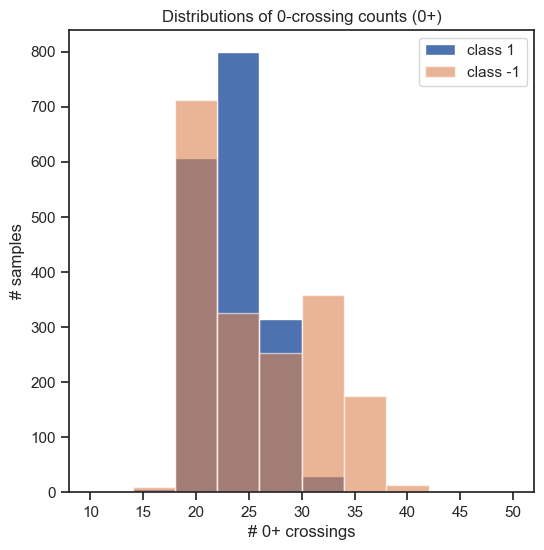

In [32]:
train.loc[train["label"]==1, "zero+"].plot(kind="hist", range=(10, 50), label="class 1")
train.loc[train["label"]==-1, "zero+"].plot(kind="hist", range=(10, 50), alpha=0.6, label="class -1")

plt.legend(loc=0)
plt.xlabel("# 0+ crossings")
plt.ylabel("# samples")
plt.title("Distributions of 0-crossing counts (0+)", fontsize=12);

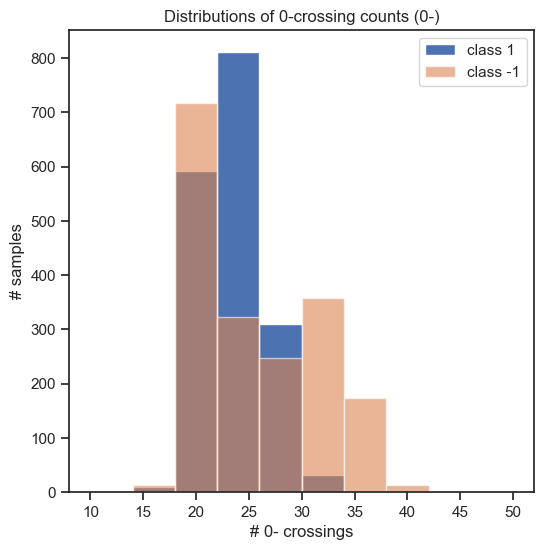

In [33]:
train.loc[train["label"]==1, "zero-"].plot(kind="hist", range=(10, 50), label="class 1")
train.loc[train["label"]==-1, "zero-"].plot(kind="hist", range=(10, 50), alpha=0.6, label="class -1")

plt.legend(loc=0)
plt.xlabel("# 0- crossings")
plt.ylabel("# samples")
plt.title("Distributions of 0-crossing counts (0-)", fontsize=12);

Of course, for oscillatory time series `zero+` and `zero-` are highly correlated, so we may drop one of them:

In [34]:
train.filter(like="zero").corr()

zero+     zero-
zero+  1.000000  0.988801
zero-  0.988801  1.000000

In [35]:
train.drop("zero-", axis=1, inplace=True)

The distribution of `zero+` looks fancy, and ROC curve reflects that:

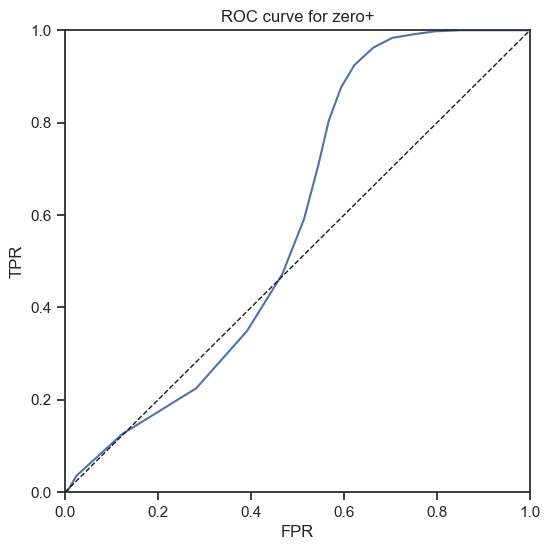

In [36]:
fpr, tpr, thr = roc_curve(train["label"], -train["zero+"])

plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], "--", c="k", linewidth=1)
plt.xlim(0, 1)
plt.ylim(0, 1)

plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("ROC curve for zero+", fontsize=12);

Think on this in the following way.

Look at the histograms, and perform an estimate (no code, just in your head): given, that `zero+` is equal to `v`, what is the probability of a sample to belong to class `1`? Is this probability monotonic with `v`? How does this influence the choice of the model? Will logistic regression do the job here?

### Response
- The probability of predicting class 1 is not monotonic with zero+, as it starts lower, gets higher, and then gets lower again based on the histogram
- Based on the histogram, there is no clear threshold for logistic regression to seperate the two labels/classes. 
- Based on the ROC there is a sweet spot that would maximize the TPR relative to the FPR.

## Exploration

In [37]:
# plot other features here - you may find various spectral features helpful here
# perform an analysis similar to one we did with number of 0-crossings
# beware of NaNs - some statistics may be broken for some rows

In [38]:
# pip install tsfresh

In [39]:
import tsfresh
from tsfresh import extract_relevant_features, extract_features
import numpy as np

In [40]:
# Reshape data to work with tsfresh
stacked_train = train.filter(like="val_").rename_axis(index="sample", columns="time").stack().to_frame(name="val").reset_index()

# Let tsfresh extract and select relevant features (this takes about 15 minutes)
features_filtered = extract_relevant_features(stacked_train, train["label"], column_id="sample", column_sort="time")

# Save extracted features to file since the extraction is a very slow process.
features_filtered.to_excel("features_filtered.xlsx")

Feature Extraction: 100%|██████████| 10/10 [20:50<00:00, 125.03s/it]


In [41]:
# If we're not re-running feature extraction, just load saved data.
# features_filtered = pd.read_excel("features_filtered.xlsx", index_col=0)

In [42]:
features_filtered

val__percentage_of_reoccurring_values_to_all_values  \
0                                              0.142191     
1                                              0.000000     
2                                              0.156398     
3                                              0.141844     
4                                              0.097561     
...                                                 ...     
3596                                           0.139535     
3597                                           0.000000     
3598                                           0.134259     
3599                                           0.000000     
3600                                           0.122970     

      val__ratio_value_number_to_time_series_length  val__has_duplicate  \
0                                             0.858                 1.0   
1                                             1.000                 0.0   
2                                             0.844                 1.0   
3                                             0.846                 1.0   
4                                             0.902                 1.0   
...                                             ...                 ...   
3596                                          0.860                 1.0   
3597                                          1.000                 0.0   
3598                                          0.864                 1.0   
3599                                          1.000                 0.0   
3600                                          0.862                 1.0   

      val__percentage_of_reoccurring_datapoints_to_all_datapoints  \
0                                                 0.264             
1                                                 0.000             
2                                                 0.288             
3                                                 0.274             
4                                                 0.186             
...                                                 ...             
3596                                              0.260             
3597                                              0.000             
3598                                              0.252             
3599                                              0.000             
3600                                              0.244             

      val__has_duplicate_max  val__ar_coefficient__coeff_7__k_10  \
0                        0.0                           -0.036560   
1                        0.0                           -0.049899   
2                        0.0                           -0.024160   
3                        0.0                           -0.029730   
4                        0.0                           -0.011098   
...                      ...                                 ...   
3596                     1.0                           -0.037512   
3597                     0.0                           -0.054179   
3598                     0.0                           -0.021878   
3599                     0.0                           -0.042754   
3600                     0.0                           -0.035535   

      val__autocorrelation__lag_9  val__approximate_entropy__m_2__r_0.1  \
0                       -0.101267                              0.710251   
1                       -0.239893                              0.683181   
2                       -0.060029                              0.677970   
3                       -0.362333                              0.659329   
4                       -0.201895                              0.727191   
...                           ...                                   ...   
3596                    -0.341646                              0.667031   
3597                    -0.434327                              0.703439   
3598                    -0.241971                  

In [43]:
# Print extracted feature names
print("\n".join(features_filtered.columns))

val__percentage_of_reoccurring_values_to_all_values
val__ratio_value_number_to_time_series_length
val__has_duplicate
val__percentage_of_reoccurring_datapoints_to_all_datapoints
val__has_duplicate_max
val__ar_coefficient__coeff_7__k_10
val__autocorrelation__lag_9
val__approximate_entropy__m_2__r_0.1
val__agg_autocorrelation__f_agg_"median"__maxlag_40
val__partial_autocorrelation__lag_5
val__spkt_welch_density__coeff_5
val__ar_coefficient__coeff_8__k_10
val__partial_autocorrelation__lag_6
val__fft_coefficient__attr_"abs"__coeff_10
val__fft_coefficient__attr_"abs"__coeff_50
val__fft_coefficient__attr_"abs"__coeff_49
val__fft_coefficient__attr_"abs"__coeff_11
val__fft_coefficient__attr_"abs"__coeff_45
val__fft_coefficient__attr_"abs"__coeff_18
val__fft_coefficient__attr_"abs"__coeff_12
val__fft_coefficient__attr_"abs"__coeff_51
val__fft_coefficient__attr_"abs"__coeff_9
val__number_cwt_peaks__n_5
val__fft_coefficient__attr_"abs"__coeff_13
val__fft_coefficient__attr_"abs"__coeff_85
val__fft_

In [44]:
# Obtain list of correlated features (where correlation > 0.99)
corr_threshold = 0.99
correlated_features = set()

feature_xcorr = features_filtered.corr()

for col in features_filtered.columns:
   if col in correlated_features:
      continue

   col_correlations = feature_xcorr[col]
   highly_correlated_feature = col_correlations.index[col_correlations.abs() > corr_threshold].to_list()
   highly_correlated_feature.remove(col)
   
   correlated_features = correlated_features.union(set(highly_correlated_feature))

uncorrelated_features = features_filtered.columns[~features_filtered.columns.isin(correlated_features)]

In [45]:
# Test that there are no longer correlated features.
abs_corr_uncorr_features = features_filtered[uncorrelated_features].corr().abs()
((abs_corr_uncorr_features > 0.99) & (abs_corr_uncorr_features != 1.0)).any().any()

False

In [46]:
correlated_features

{'val__absolute_sum_of_changes',
 'val__autocorrelation__lag_1',
 'val__change_quantiles__f_agg_"mean"__isabs_True__qh_1.0__ql_0.0',
 'val__cid_ce__normalize_False',
 'val__cid_ce__normalize_True',
 'val__count_above__t_0',
 'val__count_above_mean',
 'val__count_below_mean',
 'val__partial_autocorrelation__lag_1',
 'val__percentage_of_reoccurring_datapoints_to_all_datapoints',
 'val__permutation_entropy__dimension_4__tau_1',
 'val__permutation_entropy__dimension_5__tau_1',
 'val__permutation_entropy__dimension_7__tau_1',
 'val__range_count__max_0__min_-1000000000000.0',
 'val__range_count__max_1000000000000.0__min_0',
 'val__ratio_beyond_r_sigma__r_1',
 'val__ratio_value_number_to_time_series_length'}

In [47]:
# Compute area under ROC curve for all uncorrelated features (sorted from best to worst).
auc_values = {}
for col in uncorrelated_features:
    auc_values[col] = roc_auc_score(train["label"], features_filtered[col])
auc_features = pd.Series(auc_values)
auc_features.sort_values(ascending=False).head(30)

val__agg_autocorrelation__f_agg_"median"__maxlag_40            0.722241
val__fft_coefficient__attr_"abs"__coeff_28                     0.650216
val__fft_coefficient__attr_"abs"__coeff_69                     0.646062
val__fft_coefficient__attr_"abs"__coeff_74                     0.643429
val__fft_coefficient__attr_"abs"__coeff_62                     0.640808
val__fft_coefficient__attr_"abs"__coeff_17                     0.639614
val__fft_coefficient__attr_"abs"__coeff_25                     0.635335
val__spkt_welch_density__coeff_8                               0.634936
val__agg_autocorrelation__f_agg_"mean"__maxlag_40              0.631227
val__fft_coefficient__attr_"abs"__coeff_24                     0.623242
val__fft_coefficient__attr_"abs"__coeff_29                     0.623170
val__fft_coefficient__attr_"abs"__coeff_61                     0.622391
val__fft_coefficient__attr_"abs"__coeff_16                     0.620994
val__fft_coefficient__attr_"abs"__coeff_73                     0

In [48]:
# Use only uncorrelated features.
features_train = features_filtered[uncorrelated_features].copy()

In [49]:
# Extract the selected features on the test set.

# Get settings for generating the selected features.
kind_to_fc_parameters = tsfresh.feature_extraction.settings.from_columns(features_train)

# Reshape data to work with tsfresh
stacked_test = test.filter(like="val_").rename_axis(index="sample", columns="time").stack().to_frame(name="val").reset_index()

# Extract same features used on training set (takes 3 minutes)
features_test = extract_features(stacked_test, column_id="sample", column_sort="time", kind_to_fc_parameters=kind_to_fc_parameters)

Feature Extraction: 100%|██████████| 10/10 [07:34<00:00, 45.43s/it]


In [50]:
# Ensure feature names are in the same order for train and test.
features_test = features_test[features_train.columns].copy()

# Task 4: modeling

Given all the features you selected in Tasks 2 and 3, create a binary  classification model. You need to perform:

- reasonable train/validation split of `train`,
- select a model type (out of those, available in `sklearn`, no need to go for, say, gradient boosting),
- train a model, validate it and calculate the final score (ROC AUC) for the test set.

In [51]:
# do the train/validation split
# train a model
# check the performance on the test set

In [52]:
import sklearn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn import metrics
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

#### Use only manually computed dataset statistics as features

In [53]:
# Logistic Regression with default parameters.
print("Logistic Regression:")
model = Pipeline([
    ('scaler', StandardScaler()), 
    ('logit', LogisticRegression())
])

model.fit(train.filter(like="data_"), train["label"])
cv_scores = cross_val_score(model, train.filter(like="data_"), train["label"], scoring="roc_auc", n_jobs=-1)
print(f"    CV ROC AUC Score: {cv_scores.mean():.2%} ({cv_scores.std():.2%} std)")
print(f"    Test ROC AUC Score: {metrics.roc_auc_score(test['label'], model.predict(test.filter(like='data_'))):.2%}")

Logistic Regression:
    CV ROC AUC Score: 55.12% (1.31% std)
    Test ROC AUC Score: 53.10%


In [54]:
# SVC with default parameters.
print("SVM:")
model = Pipeline([
    ('scaler', StandardScaler()), 
    ('svc', SVC())
])

model.fit(train.filter(like="data_"), train["label"])
cv_scores = cross_val_score(model, train.filter(like="data_"), train["label"], scoring="roc_auc", n_jobs=-1)
print(f"    CV ROC AUC Score: {cv_scores.mean():.2%} ({cv_scores.std():.2%} std)")
print(f"    Test ROC AUC Score: {metrics.roc_auc_score(test['label'], model.predict(test.filter(like='data_'))):.2%}")

SVM:
    CV ROC AUC Score: 63.64% (1.84% std)
    Test ROC AUC Score: 56.56%


In [55]:
# RandomForestClassifier with default parameters.
print("Random Forest:")
model = Pipeline([
    ('forest', RandomForestClassifier())
])

model.fit(train.filter(like="data_"), train["label"])
cv_scores = cross_val_score(model, train.filter(like="data_"), train["label"], scoring="roc_auc", n_jobs=-1)
print(f"    CV ROC AUC Score: {cv_scores.mean():.2%} ({cv_scores.std():.2%} std)")
print(f"    Test ROC AUC Score: {metrics.roc_auc_score(test['label'], model.predict(test.filter(like='data_'))):.2%}")

Random Forest:
    CV ROC AUC Score: 61.40% (2.14% std)
    Test ROC AUC Score: 57.63%


#### Try using uncorrelated features selected by tsfresh

In [56]:
# Logistic Regression with default parameters.
print("Logistic Regression:")
model = Pipeline([
    ('scaler', StandardScaler()), 
    ('logit', LogisticRegression())
])

model.fit(features_train, train["label"])
cv_scores = cross_val_score(model, features_train, train["label"], scoring="roc_auc", n_jobs=-1)
print(f"    CV ROC AUC Score: {cv_scores.mean():.2%} ({cv_scores.std():.2%} std)")
print(f"    Test ROC AUC Score: {metrics.roc_auc_score(test['label'], model.predict(features_test)):.2%}")

Logistic Regression:
    CV ROC AUC Score: 100.00% (0.00% std)
    Test ROC AUC Score: 100.00%


In [57]:
# SVC with default parameters.
print("SVM:")
model = Pipeline([
    ('scaler', StandardScaler()), 
    ('svc', SVC())
])

model.fit(features_train, train["label"])
cv_scores = cross_val_score(model, features_train, train["label"], scoring="roc_auc", n_jobs=-1)
print(f"    CV ROC AUC Score: {cv_scores.mean():.2%} ({cv_scores.std():.2%} std)")
print(f"    Test ROC AUC Score: {metrics.roc_auc_score(test['label'], model.predict(features_test)):.2%}")

SVM:
    CV ROC AUC Score: 99.99% (0.00% std)
    Test ROC AUC Score: 99.77%


In [58]:
# RandomForestClassifier with default parameters.
print("Random Forest:")
model = Pipeline([
    ('forest', RandomForestClassifier())
])

model.fit(features_train, train["label"])
cv_scores = cross_val_score(model, features_train, train["label"], scoring="roc_auc", n_jobs=-1)
print(f"    CV ROC AUC Score: {cv_scores.mean():.2%} ({cv_scores.std():.2%} std)")
print(f"    Test ROC AUC Score: {metrics.roc_auc_score(test['label'], model.predict(features_test)):.2%}")

Random Forest:
    CV ROC AUC Score: 100.00% (0.00% std)
    Test ROC AUC Score: 100.00%


- Using the uncorrelated features selected by tsfresh, Logistic Regression and Random Forest (using default parameters) obtain 100% classification accuracy on both the train/CV set and the test set.
- Using the default parameters, SVM does not quite reach 100%, but can almost certainly be tuned to achieve that result